## Initialization

In [1]:
#!pip install opencv-python
#%pip install mpmath
import os # For directories 
import numpy as np 
import pandas as pd
from mpmath import besselj, besseljzero
from skimage import io 
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
#from skimage.morphology import (closing, square erosion, dilation, opening, area_closing, area_opening)
from skimage.morphology import (closing, square, erosion, dilation, closing, opening,
                                area_closing, area_opening)
from math import exp
from skimage.color import label2rgb, rgb2gray
from skimage.io import imread, imshow
from skimage.filters import difference_of_gaussians, gaussian
from skimage.draw import disk, ellipse
from scipy import misc
import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline 
import matplotlib.patches as mpatches
import seaborn as sns; sns.set()  
import ipywidgets as widgets 
from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Layout, GridspecLayout
from ipywidgets.embed import embed_minimal_html, dependency_state
from scipy import stats, integrate
from scipy.optimize import curve_fit
from pathlib import Path, PureWindowsPath # for working with windows paths
import glob

## Functions

In [252]:
import numpy as np

def create_circle(dimx, dimy, x, y, r):
    # Create a meshgrid of x and y indices
    xx, yy = np.meshgrid(np.arange(dimx), np.arange(dimy))

    # Calculate distances from each point to the center (x, y)
    distances = np.sqrt((xx - x)**2 + (yy - y)**2)

    # Create a binary array where points inside the circle are True (1) and outside are False (0)
    circle_array = (distances <= r).astype(int)

    return circle_array

In [6]:
import pandas as pd

def normalize_intensity(df, N):
    """
    Normalize the intensity to the average of the first N frames for each channel.

    Parameters:
    - df: DataFrame containing the columns 'Intensity', 'r (nm)', 't (sec)', 'ch', and 'frame'.
    - N: The number of frames to calculate the average intensity.

    Returns:
    - DataFrame with the normalized 'Intensity' column.
    """
    # Ensure the frame column is sorted, in case it's not
    df = df.sort_values(by=['ch', 'frame'])

    # Calculate the average intensity for the first N frames for each channel
    avg_intensity = df[df['frame'] < N].groupby('ch')['Intensity'].mean().reset_index()
    avg_intensity.columns = ['ch', 'avg_intensity']

    # Merge the average intensity back to the original dataframe
    df = pd.merge(df, avg_intensity, on='ch', how='left')

    # Normalize the intensity
    df['Normalized Intensity'] = df['Intensity'] / df['avg_intensity']

    # Drop the temporary avg_intensity column
    df.drop(columns=['avg_intensity'], inplace=True)

    return df

In [ ]:
def normalize_per_track(df, initial_1, initial_2, row_index_to_zero, column_to_normalize):
    # Check if the necessary columns are in the DataFrame
    required_columns = ['t', 'cell', column_to_normalize]
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"DataFrame must contain the following columns: {', '.join(missing_columns)}")
    
    # Ensure the specified row index is non-negative
    if row_index_to_zero < 0:
        raise IndexError(f"Row index {row_index_to_zero} is out of range for the DataFrame.")

    # Group by 'cell'
    grouped = df.groupby('cell')

    def adjust_and_normalize_track(group):
        # Ensure there are enough rows in the group
        if len(group) <= initial_2:
            raise IndexError(f"Group '{group.name}' has fewer rows than required for the initial index range {initial_1}:{initial_2}.")
        
        # Ensure the row_index_to_zero is within range for this group
        if row_index_to_zero >= len(group):
            raise IndexError(f"Row index {row_index_to_zero} is out of range for track '{group.name}'.")

        # Adjust the values based on row_index_to_zero
        value_at_row_index = group.iloc[row_index_to_zero][column_to_normalize]
        group = group.copy()  # Avoid SettingWithCopyWarning
        group['adjusted_value'] = group[column_to_normalize] - value_at_row_index
        
        # Filter data for initial time points
        initial_time_points = group.iloc[initial_1:initial_2]
        
        # Calculate the average of the initial time points
        initial_avg = initial_time_points['adjusted_value'].mean()
        
        if initial_avg == 0:
            raise ValueError(f"Average of initial time points is zero for track '{group.name}'; normalization cannot be performed.")
        
        # Normalize values so the average of the initial points is 1
        group['FRAP_normalized_value'] = group['adjusted_value'] / initial_avg
        
        return group

    # Apply normalization to each group
    df_normalized = grouped.apply(adjust_and_normalize_track).reset_index(drop=True)
    
    return df_normalized

# Step 0: Choose Directoy, File, & Set Independent Variables

In [824]:
dir = r'\\129.82.125.210\TSnas2\galindo\1_Imaging_Data\MPNN_intrabodies\FLAGFRAP_09052024\Frankenbody'
file_name = 'FLAGFrankenbody_Frap13.tif'

vid =  imread(os.path.join(dir,file_name))
vid = vid.transpose([1,0,2,3])
vid.shape

(2, 260, 888, 624)

In [825]:
# Parameters needed for describing the FRAP experiment
frap_frame_num = 21

# Step 1: Find position of cell and FRAP spot; subtract background

In [828]:
(ch_num, frame_num, dim_y, dim_x) = vid.shape
[ch_num, frame_num, dim_y, dim_x]

[2, 260, 888, 624]

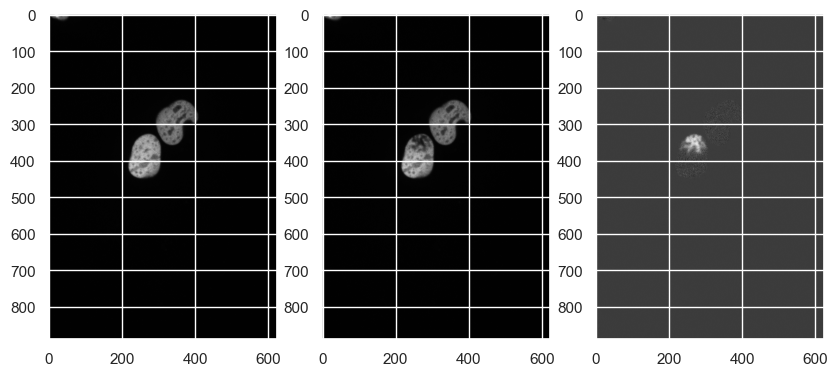

In [829]:
# To estimate where the FRAP occurred, we will take the difference between the FRAP frame and the previous frame:
#GET MASK FOR ENTIRE NUCLEUS (MAX PROJECTION)
diff_arr = np.mean(vid[0][frap_frame_num-2:frap_frame_num-1], axis =0) - np.mean(vid[0][frap_frame_num:frap_frame_num+1], axis = 0) #Difference between FRAP frame and previous frame 
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 12))
axs[0].imshow(vid[0,frap_frame_num-1], cmap='gray') ## ch2 = mCh-H2B, which we'll use to find position of FRAP
axs[1].imshow(vid[0,frap_frame_num], cmap='gray') ## ch2 = mCh-H2B, which we'll use to find position of FRAP
axs[2].imshow(diff_arr,cmap= 'gray')  
plt.show()

(350, 269)


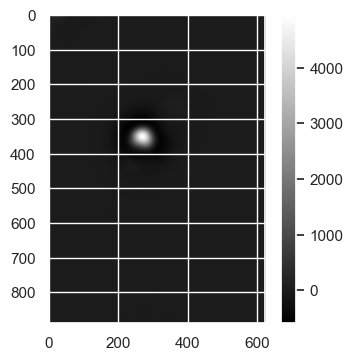

In [830]:
# Performing difference of gaussian to accentuate FRAP spot
filtered_arr = difference_of_gaussians(diff_arr, 12, 40)
max_position = np.unravel_index(np.argmax(filtered_arr), filtered_arr.shape)
print(max_position)
plt.figure(figsize=(4,4))
plt.imshow(filtered_arr,cmap= 'gray')  
plt.colorbar()
plt.show()

In [831]:
center = np.array(max_position).astype('int16')
center

array([350, 269], dtype=int16)

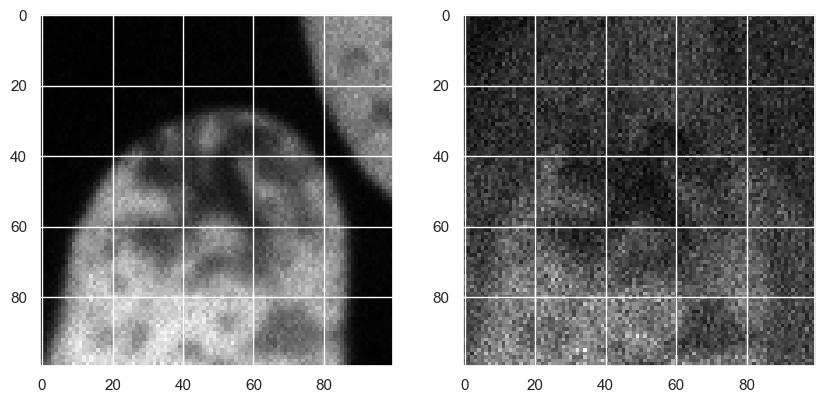

In [832]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].imshow(vid[0][frap_frame_num, center[0]-50:center[0]+50, center[1]-50:center[1]+50], cmap = 'gray')
ax[1].imshow(vid[1][frap_frame_num, center[0]-50:center[0]+50, center[1]-50:center[1]+50], cmap = 'gray')


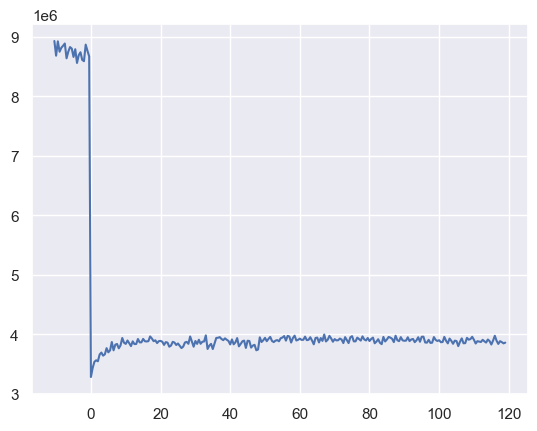

In [833]:
x = center[1]
y = center[0]
framen, dimy, dimx = vid[0].shape
r=15
frap_rec_h2b = np.array([np.sum(create_circle(dimx, dimy, x, y, r)*vid[0][i]) for i in np.arange(len(vid[0]))])
# Create an array of x-values (assuming they are just the indices of the array)
my_x = np.arange(len(vid[0]))*0.5-(21*0.5)

# Plot the values
plt.plot(my_x, frap_rec_h2b)

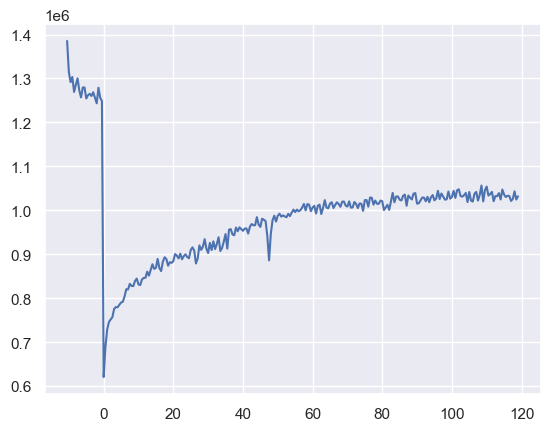

In [834]:
x = center[1]
y = center[0]
framen, dimy, dimx = vid[1].shape
r=15
frap_rec_fb = np.array([np.sum(create_circle(dimx, dimy, x, y, r)*vid[1][i]) for i in np.arange(len(vid[1]))])
# Create an array of x-values (assuming they are just the indices of the array)
my_x = np.arange(len(vid[1]))*0.5-(21*0.5)

# Plot the values
plt.plot(my_x, frap_rec_fb)

In [835]:
df = pd.DataFrame({
    't': my_x,
    'frap_rec_fb': frap_rec_fb, #specify name of intrabody
    'frap_rec_h2b': frap_rec_h2b 
})

In [836]:
#Save FRAP recovery data
df.to_csv(os.path.join(dir,file_name[:-4]+'.csv'))

# Step 2: Concatenate all Data and Plot

In [654]:
#Import and concatenate all FRAP data

# Define the directory containing the CSV files
directory = r'\\129.82.125.210\TSnas2\galindo\1_Imaging_Data\MPNN_intrabodies\TerrybodyFRAP\FRAP_CSV'

# Use glob to get a list of all CSV files in the directory
csv_files = glob.glob(os.path.join(directory, '*.csv'))

# Initialize an empty list to hold the DataFrames
dfs = []

# Loop through each CSV file
for file in csv_files:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file)
    
    # Extract the file name without extension for the 'cell' column
    file_name = os.path.basename(file)
    cell_name = os.path.splitext(file_name)[0]
    
    # Add a new column 'cell' with the cell_name
    df['cell'] = cell_name
    
    # Append the DataFrame to the list
    dfs.append(df)

# Concatenate all DataFrames in the list into one big DataFrame
big_df = pd.concat(dfs, ignore_index=True)

In [671]:
# Example parameters
initial_1 = 55
initial_2 = 60
row_index_to_zero = 21
column_to_normalize = 'frap_rec_fb'  # Specify the column you want to normalize

# Apply normalization
df_normalized = normalize_per_track(big_df, initial_1, initial_2, row_index_to_zero, column_to_normalize)

In [672]:
df = df_normalized
# Extract epitope information
df['epitope'] = df['cell'].apply(lambda x: '+ EpNP' if 'with' in x else '- EpNP')
# Extract the cell number
df['rep'] = df['cell'].str.extract(r'(\d+)$')[0]
# Reorder and select columns
df = df[['t', 'FRAP_normalized_value', 'epitope', 'rep']]

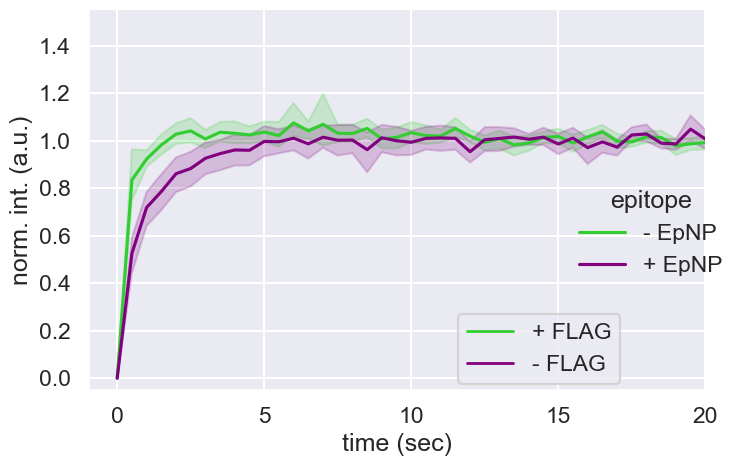

In [673]:
sns.set_style('darkgrid')
sns.set_context('talk')

# Create a line plot using relplot
g = sns.relplot(data=df[df['t']>=0],x="t",y="FRAP_normalized_value",hue="epitope", kind="line",palette=['limegreen', 'purple'],aspect=1.2)

# Add custom labels and limits
plt.xlabel("time (sec)")
plt.ylabel("norm. int. (a.u.)")
plt.xlim(-1, 20)
plt.ylim(-0.05,1.55)
plt.xticks(ticks=[0, 5, 10, 15, 20])

custom_lines = [
    Line2D([0], [0], color='limegreen', lw=2, label='+ FLAG'),
    Line2D([0], [0], color='purple', lw=2, label='- FLAG')]

plt.legend(handles=custom_lines,bbox_to_anchor=(0.6, 0.2),loc=2,borderaxespad=0.)
plt.tight_layout()

# Show the plot
#plt.savefig(r'\\129.82.125.210\TSnas2\SharedExternal\OurPapers\MPNN-Paper\Fig1\1G\frap_updated.svg')

In [647]:
df.to_csv(r'\\129.82.125.210\TSnas2\SharedExternal\OurPapers\MPNN-Paper\Fig1\1G\FRAP_data.csv')